In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import scores

from transformers import AutoModel, BertModel, DistilBertModel

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def getscoresBERT(l,model):
    """
    Let Q and K be
    Q = X @ W_q ; K = X @ W_k

    it follows that the dot product between queries and keys is 
    Q @ K^T = X @ (W_q @ W_k^T) @ X^T = X @ M @ X^T 

    where M is a square matrix \in R^{d,d}, that can be decomposed into its
    symmetric and skew-symmetric part S and N, respectively,
    M = 1/2 * (M + M^T) + 1/2 * (M - M^T) = S + N

    important: nn.Linear.weight returns the learnable weights of the module as
    (out_features,in_features), then we can access the matrix W_q or 
    W_k as nn.Linear.weight^T

    Args:
        - l (int) : total number of layers
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros(l)
    NList = np.zeros(l)
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.encoder.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention

        # access W_q and W_k by transposing the weight matrix
        Wv = self_attention.self.value._parameters["weight"].T.detach().numpy()
        Wo = self_attention.output.dense._parameters["weight"].T.detach().numpy()
        
        # calculate the association matrix M
        M = Wv @ Wo
        # compute symmetry and skew-symmetry scores
        S, N = scores(M)
        SList[i], NList[i] = S, N

    return  SList, NList

def getscoresDistillBERT(l,model):
    """ 
    Args:
        - l (int) : total number of layers
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros(l)
    NList = np.zeros(l)

    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.transformer.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention

        # access W_q and W_k by transposing the weight matrix 
        Wv = self_attention.v_lin._parameters["weight"].T.detach().numpy()
        Wo = self_attention.out_lin._parameters["weight"].T.detach().numpy()

        # calculate the association matrix M
        M = Wv @ Wo
        # compute symmetry and skew-symmetry scores
        S, N = scores(M)
        SList[i], NList[i] = S, N

    return  SList, NList

In [7]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../../_data/fig_scores/BERT-value-out-full.pkl'):
    with open('../../_data/fig_scores/BERT-value-out-full.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [8]:
""" 
BERT models 
 - MODEL: Bidirectional, Encoder-only Transformer
 - DATASETS: BookCorpus & English Wikipedia
 - OBJECTIVES: Masked Language Modeling (MLM), Next Sentence Prediction (NSP)
 - METRICS: perplexity, cross-entropy

 MLM: randomly masked some words in the sentence, predict masked words with cross-entropy 
 over the vocabulary 
 NSP: 

The idea is that these models have a better understanding of context, where each word is represented as a 
linear combination of all the other words in the sentence, bi-directionally.
"""
dh = 64

'BERT tiny (l = 2, d = 128, h = 2 ; 4.40M parameters)'
l = 2
d = 128
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
S, N = getscoresBERT(l,model)
models['BERTtiny'] = [l,d,h,dh,S,N]

'BERT mini (l = 4, d = 256, h = 4 ; 11.3M parameters)'
l = 4
d = 256
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-256_A-4")
S, N = getscoresBERT(l,model)
models['BERTmini'] = [l,d,h,dh,S,N]

'BERT small (l = 4, d = 512, h = 8 ; 29.1M parameters)'
l = 4
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-4_H-512_A-8")
S, N = getscoresBERT(l,model)
models['BERTsmall'] = [l,d,h,dh,S,N]

'BERT medium (l = 8, d = 512, h = 8 ; 41.7M parameters)'
l = 8
d = 512
h = d // dh
model = AutoModel.from_pretrained("google/bert_uncased_L-8_H-512_A-8")
S, N = getscoresBERT(l,model)
models['BERTmedium'] = [l,d,h,dh,S,N]

'BERT base (l = 12, d = 768, h = 12 ; 110M parameters)'
l = 12
d = 768
h = d // dh
model = BertModel.from_pretrained("bert-base-uncased")
S, N = getscoresBERT(l,model)
models['BERTbase'] = [l,d,h,dh,S,N]

'BERT large (l = 24, d = 1024, h = 16 ; 340M parameters)'
l = 24
d = 1024
h = d // dh
model = BertModel.from_pretrained("bert-large-uncased")
S, N = getscoresBERT(l,model)
models['BERTlarge'] = [l,d,h,dh,S,N]

'DistillBERT base model (l = 6, d = 768, h = 12 ; tot num parameters 66M)'
l = 6
d = 768
h = d // dh
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
S, N = getscoresDistillBERT(l,model)
models['DistillBERT'] = [l,d,h,dh,S,N]

'save'
with open('../../_data/fig_scores/BERT-value-out-full.pkl', 'wb') as file:
    pickle.dump(models, file)

(0.0, 1.0)

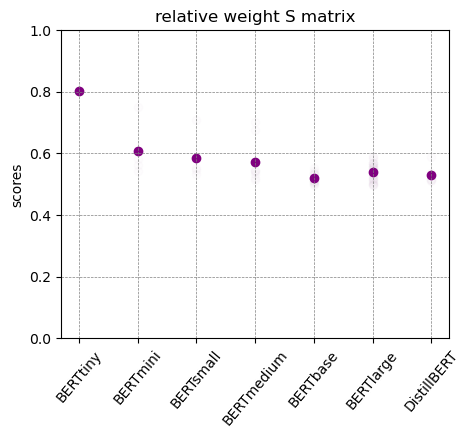

In [9]:
with open('../../_data/fig_scores/BERT-value-out-full.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.01)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='purple')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight S matrix')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=50)
plt.ylim(0,1)